## Confusion matrix & metrics

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# classification 위한 임의의 데이터 생성 -> X: 2개 feature, y:binary 인 데이터 샘플 100개
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0) #x값에 2개의 feature 지정

In [2]:
model = LogisticRegression().fit(X,y)
y_pred = model.predict(X)
y_score = model.decision_function(X)  # decision_function(): 판별함수 값 계산
# y_score(계산된 판별함수 값)가 양수이면 y=1, 음수이면 y=0으로 분류

# 데이터프레임 형태로 확인해 보자
df = pd.DataFrame(np.vstack([y_score, y_pred, y]).T,
                  columns=["y_score", "y_pred", "y"])
df = df.sort_values("y_score", ascending=False).reset_index(drop=True)
display(df.head(), df.tail())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,y_score,y_pred,y
0,10.960712,1.0,1.0
1,8.579686,1.0,1.0
2,7.709356,1.0,1.0
3,6.719817,1.0,1.0
4,6.494104,1.0,1.0


,y_score,y_pred,y
95,-5.618467,0.0,0.0
96,-5.644874,0.0,0.0
97,-5.836798,0.0,0.0
98,-7.183429,0.0,0.0
99,-8.134024,0.0,0.0


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

# 지표 확인
print(confusion_matrix(y, y_pred)) # TP FN FP TN
display(accuracy_score(y, y_pred), precision_score(y, y_pred), recall_score(y, y_pred), f1_score(y, y_pred))
print(classification_report(y, y_pred))

[[46  5]
 [ 2 47]]


0.93

0.9038461538461539

0.9591836734693877

0.9306930693069307

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        51
           1       0.90      0.96      0.93        49

   micro avg       0.93      0.93      0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [43]:
# threshold를 0이 아닌 -2로 지정해 보자 
lower_threshold = model.decision_function(X) > -2 #-2보다 큰경우 1로 분류, -2보다 작은경우 0으로 분류

df2 = pd.DataFrame(np.vstack([y_score, lower_threshold, y]).T,
                  columns=["y_score", "y_hat", "y"])
df2 = df2.sort_values("y_score", ascending=False).reset_index(drop=True)
display(df2[(df2['y_score']> -2.5) & (df2['y_score']<-1.5)])

print(confusion_matrix(y, lower_threshold))
print(classification_report(y, lower_threshold))

,y_score,y_hat,y
66,-1.504060,1.0,0.0
67,-1.586684,1.0,0.0
68,-1.711021,1.0,0.0
69,-1.761630,1.0,0.0
70,-1.968663,1.0,0.0
71,-2.147105,0.0,0.0
72,-2.287081,0.0,0.0
73,-2.425482,0.0,0.0


[[29 22]
 [ 0 49]]
             precision    recall  f1-score   support

          0       1.00      0.57      0.72        51
          1       0.69      1.00      0.82        49

avg / total       0.85      0.78      0.77       100



## ROC, PR 곡선 그리기

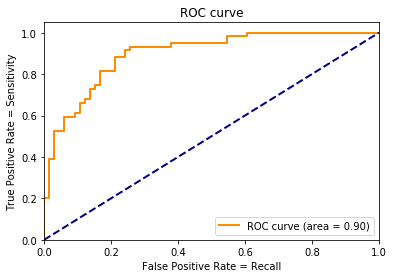

In [71]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# model = LogisticRegression()

y_score = model.fit(X_train, y_train).decision_function(X_test)

# decision_function()을 사용할 수 없는 모델의 경우 y_score 대신 predict_proba()로 확률값을 구해줌
# probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1] # 0,1 중 1로 분류될 확률

# calculate AUC
roc_auc = roc_auc_score(y_test, y_score)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate = Recall')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

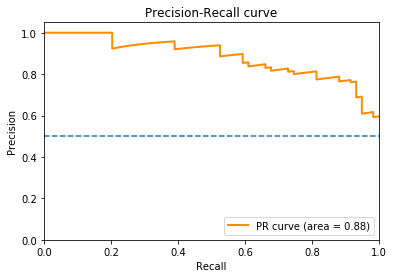

In [72]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# calculate precision-recall AUC
pr_auc = auc(recall, precision)

plt.plot(recall, precision, lw=2, color='darkorange', label='PR curve (area = %0.2f)' % pr_auc)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

## Cross Validation

In [32]:
# kFold 모듈
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=0) #1과 0 값 섞어주기
for train_index, test_index in cv.split(X):
    print(X[train_index], y[test_index])
# cv.split(X)는 X를 k-fold로 나눈 뒤 각 fold에서의 (train_index, test_index)를 반환하는 iterable

[[-0.22797043 -0.65989727]
 [ 0.23729822  0.53098715]
 [ 0.90816202  0.29764902]
 ...
 [ 1.60151187  0.70757717]
 [ 0.09376888  0.38732615]
 [-2.36542865 -1.5726754 ]] [0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0
 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1
 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1
 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1
 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1
 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0
 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1
 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0
 1]
[[-2.30498574 -1.65681633]
 [-2.03490046 -1.53587567]
 [-0.39989496 -0.70292241]
 ...
 [ 1.67689305  1.0876581 ]
 [ 1.02288554 -0.52887796]
 [-0.58961569

In [33]:
# cross_val_score 모듈
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0) # target이 골고루 분포되도록 shuffle 옵션
scores = cross_val_score(LogisticRegression(), X, y, cv=kfold)
# cross_val_score(모델, 데이터, 타깃)
scores # 각 fold에 대한 score

array([0.955, 0.92 , 0.96 , 0.95 , 0.93 ])

In [34]:
scores = cross_val_score(LogisticRegression(), X, y) 
scores 
# cross_val_score의 기본값은 k=3

array([0.93413174, 0.94594595, 0.94594595])

In [35]:
scores = cross_val_score(LogisticRegression(), X, y, cv=5)
scores
# cross_val_score는 기본적으로 분류 모델에 대해 StratifiedKfold(그냥 kfold 보다는 데이터 불균형 많을 때 사용하면 better) 사용

array([0.92537313, 0.94029851, 0.95      , 0.95477387, 0.93969849])

In [36]:
display(scores.mean(), scores.var()) # 교차검증 점수들의 평균과 분산 확인

0.9420288007200179

0.00010236245330868884

## Grid Search

In [37]:
# 딕셔너리 형태로 시험할 파라미터를 지정
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1','l2']}
# 로지스틱 회귀의 경우 주요 파라미터: C, penalty 등
# 이 경우 파라미터'C'값 6개, 'penalty'값 2개의 조합 => 총 6x2=12번 모델 돌리게 됨

In [38]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5) # 보통 교차검증을 사용한 그리드 서치를 시행! 보통 5번을 많이 사용
# GridSearchCV(모델, 파라미터 딕셔너리)
grid_search.fit(X, y)

print('최적의 파라미터: ', grid_search.best_params_)
print('최고 성능 모델: ', grid_search.best_estimator_)
print('최고 교차검증 점수: {:.2f}'.format(grid_search.best_score_))

최적의 파라미터:  {'C': 10, 'penalty': 'l1'}
최고 성능 모델:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
최고 교차검증 점수: 0.94


In [39]:
# 데이터프레임으로 교차검증 결과 확인해보자 (grid_search.cv_results_)
pd.set_option('display.max_columns', None)
results = pd.DataFrame(grid_search.cv_results_)
# 처음 다섯 개 행 출력
display(np.transpose(results.head())) #test score나 train score가 증가하는지, 시간은 어떻게 변하는지 보는게...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,0,1,2,3,4
mean_fit_time,0.00158787,0.00228257,0.00205574,0.00188508,0.00192738
std_fit_time,0.00057915,0.000507351,0.000223673,0.000198442,0.000470564
mean_score_time,0.000712252,0.000694942,0.000629807,0.000688791,0.000637484
std_score_time,0.000266401,0.000242016,0.000193803,0.000382067,0.000204024
param_C,0.001,0.001,0.01,0.01,0.1
param_penalty,l1,l2,l1,l2,l1
params,"{'C': 0.001, 'penalty': 'l1'}","{'C': 0.001, 'penalty': 'l2'}","{'C': 0.01, 'penalty': 'l1'}","{'C': 0.01, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}"
split0_test_score,0.502488,0.930348,0.935323,0.935323,0.935323
split1_test_score,0.502488,0.935323,0.935323,0.935323,0.930348
split2_test_score,0.5,0.955,0.955,0.955,0.95


# Quest

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
X = data['data']
X_1 = X[:, 0].reshape(-1,1)
y = data['target']

In [4]:
y = (y==0).astype(np.int)
log_reg = LogisticRegression()
log_reg.fit(X_1, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##mean radius 변수 사용
X_train, X_test, y_train, y_test = train_test_split(X_1, y)

y_score = log_reg.fit(X_train, y_train).decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_score)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate = Recall')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 640x480 with 1 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


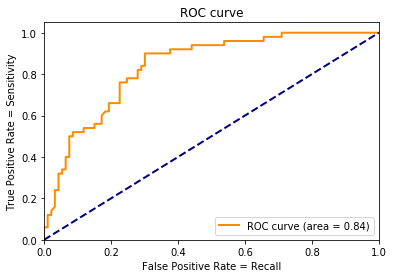

In [6]:
##mean texture 변수 사용
X = data['data']
X_2 = X[:, 1].reshape(-1,1)
y = data['target']

y = (y==0).astype(np.int)
log_reg = LogisticRegression()
log_reg.fit(X_2, y)

X_train, X_test, y_train, y_test = train_test_split(X_2, y)
y_score = log_reg.fit(X_train, y_train).decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_score)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate = Recall')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

mean radius 변수를 사용하는 모델이 AUC 값이 더 높으므로 해당 모델 선택.

In [7]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X):
    print(X_1[train_index], y[test_index])

[[17.99 ]
 [19.69 ]
 [11.42 ]
 [20.29 ]
 [12.45 ]
 [18.25 ]
 [13.71 ]
 [13.   ]
 [12.46 ]
 [15.78 ]
 [15.85 ]
 [14.68 ]
 [19.81 ]
 [13.54 ]
 [13.08 ]
 [15.34 ]
 [21.16 ]
 [16.65 ]
 [17.14 ]
 [14.58 ]
 [18.61 ]
 [15.3  ]
 [17.57 ]
 [18.63 ]
 [17.02 ]
 [19.27 ]
 [16.13 ]
 [16.74 ]
 [14.25 ]
 [14.99 ]
 [13.48 ]
 [13.44 ]
 [10.95 ]
 [19.07 ]
 [13.28 ]
 [13.17 ]
 [13.17 ]
 [12.05 ]
 [13.49 ]
 [11.76 ]
 [13.64 ]
 [11.94 ]
 [18.22 ]
 [15.1  ]
 [11.52 ]
 [19.21 ]
 [14.71 ]
 [13.05 ]
 [ 8.618]
 [10.17 ]
 [ 8.598]
 [14.25 ]
 [ 9.173]
 [14.78 ]
 [11.31 ]
 [ 9.029]
 [12.78 ]
 [18.94 ]
 [17.2  ]
 [13.8  ]
 [12.31 ]
 [13.53 ]
 [18.05 ]
 [12.86 ]
 [11.45 ]
 [13.34 ]
 [25.22 ]
 [19.1  ]
 [12.   ]
 [14.48 ]
 [19.02 ]
 [12.36 ]
 [15.37 ]
 [13.27 ]
 [13.45 ]
 [15.06 ]
 [20.26 ]
 [12.18 ]
 [ 9.787]
 [11.6  ]
 [14.42 ]
 [13.61 ]
 [ 6.981]
 [10.49 ]
 [13.11 ]
 [11.64 ]
 [11.34 ]
 [ 9.777]
 [12.63 ]
 [14.26 ]
 [10.51 ]
 [ 8.726]
 [11.93 ]
 [ 8.95 ]
 [14.87 ]
 [17.95 ]
 [11.41 ]
 [18.66 ]
 [24.25 ]
 [14.5  ]


[[20.57 ]
 [19.69 ]
 [11.42 ]
 [20.29 ]
 [12.45 ]
 [18.25 ]
 [13.71 ]
 [13.   ]
 [16.02 ]
 [15.78 ]
 [19.17 ]
 [15.85 ]
 [13.73 ]
 [14.54 ]
 [14.68 ]
 [16.13 ]
 [19.81 ]
 [13.54 ]
 [13.08 ]
 [ 9.504]
 [15.34 ]
 [16.65 ]
 [17.14 ]
 [14.58 ]
 [18.61 ]
 [17.57 ]
 [18.63 ]
 [11.84 ]
 [17.02 ]
 [19.27 ]
 [16.13 ]
 [16.74 ]
 [14.25 ]
 [13.03 ]
 [14.99 ]
 [13.48 ]
 [13.44 ]
 [10.95 ]
 [13.17 ]
 [18.65 ]
 [ 8.196]
 [13.49 ]
 [13.64 ]
 [11.94 ]
 [15.1  ]
 [11.52 ]
 [19.21 ]
 [13.05 ]
 [ 8.618]
 [10.17 ]
 [ 8.598]
 [ 9.173]
 [12.68 ]
 [14.78 ]
 [ 9.465]
 [11.31 ]
 [ 9.029]
 [ 8.888]
 [13.8  ]
 [12.31 ]
 [16.07 ]
 [13.53 ]
 [18.05 ]
 [20.18 ]
 [12.86 ]
 [11.45 ]
 [13.34 ]
 [19.1  ]
 [18.46 ]
 [14.48 ]
 [12.36 ]
 [14.64 ]
 [14.62 ]
 [13.27 ]
 [13.45 ]
 [12.18 ]
 [ 9.787]
 [13.61 ]
 [ 6.981]
 [12.18 ]
 [ 9.876]
 [10.49 ]
 [13.11 ]
 [11.64 ]
 [12.36 ]
 [22.27 ]
 [11.34 ]
 [ 9.777]
 [12.63 ]
 [14.26 ]
 [10.51 ]
 [ 8.726]
 [ 8.95 ]
 [14.87 ]
 [15.78 ]
 [11.41 ]
 [18.66 ]
 [24.25 ]
 [13.37 ]
 [13.85 ]


In [8]:
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0) 
scores = cross_val_score(LogisticRegression(), X_1, y, cv=kfold)

scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

array([0.88596491, 0.90350877, 0.84210526, 0.88596491, 0.89380531])

In [9]:
scores = cross_val_score(LogisticRegression(), X_1, y, cv=5) 
scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

array([0.83478261, 0.84347826, 0.88495575, 0.95575221, 0.92035398])

In [10]:
param_grid = {'C' : scores, 'penalty': ['l1','l2']}

In [11]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5) 
grid_search.fit(X_1, y)

print('최적의 파라미터: ', grid_search.best_params_)
print('최고 성능 모델: ', grid_search.best_estimator_)
print('최고 교차검증 점수: {:.2f}'.format(grid_search.best_score_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

최적의 파라미터:  {'C': 0.9203539823008849, 'penalty': 'l2'}
최고 성능 모델:  LogisticRegression(C=0.9203539823008849, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
최고 교차검증 점수: 0.89


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
pd.set_option('display.max_columns', None)
results = pd.DataFrame(grid_search.cv_results_)

display(np.transpose(results.head()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,0,1,2,3,4
mean_fit_time,0.0250007,0.00312333,0.0187463,0.00624442,0.0437489
std_fit_time,0.0124999,0.00624666,0.00625271,0.00764783,0.0182212
mean_score_time,0.00312581,0.00312414,0.00626035,0.00312576,0.00624819
std_score_time,0.00625162,0.00624828,0.00766733,0.00625153,0.00765244
param_C,0.834783,0.834783,0.843478,0.843478,0.884956
param_penalty,l1,l2,l1,l2,l1
params,"{'C': 0.8347826086956521, 'penalty': 'l1'}","{'C': 0.8347826086956521, 'penalty': 'l2'}","{'C': 0.8434782608695652, 'penalty': 'l1'}","{'C': 0.8434782608695652, 'penalty': 'l2'}","{'C': 0.8849557522123894, 'penalty': 'l1'}"
split0_test_score,0.834783,0.826087,0.834783,0.826087,0.834783
split1_test_score,0.843478,0.843478,0.843478,0.843478,0.843478
split2_test_score,0.884956,0.876106,0.884956,0.876106,0.884956
